<a href="https://colab.research.google.com/github/vanphuoc9/object-deatch-colab/blob/master/finish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install the prerequisites

In [0]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install Cython
!pip install jupyter
!pip install matplotlib 

Clone the Tensorflow models repository

In [0]:
!git clone https://github.com/tensorflow/models.git

Clone the COCO repository and install the COCO object detection api (this is actually needed only for eval but anyways, we follow the instructions)

In [0]:
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools /content/models/research/

Set the environment for all future operations. You need to run this part if you restart your runtime.

In [4]:
%cd /content/models/research
!mkdir train eval

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim

/content/models/research
env: PYTHONPATH=/content/models/research:/content/models/research/slim


Compile the model definitions

In [0]:
!protoc object_detection/protos/*.proto --python_out=.

Test that everything we need is installed

In [6]:
!python object_detection/builders/model_builder_test.py

......................
----------------------------------------------------------------------
Ran 22 tests in 0.125s

OK


# Download and extract dataset

    Change name attribute in label_map, accordingly with objectclass filename.
    Substitute fileId value with your dataset.zip id in Google Drive. See here my answer to get file id.


In [32]:
%cd /content

/content


In [0]:
!mkdir datalab

In [34]:
%cd datalab

/content/datalab


Create label_map.pbtxt

In [0]:
!echo "item {id: 1 name: 'dog'}" > label_map.pbtxt

In [36]:
cat label_map.pbtxt

item {id: 1 name: 'dog'}


# Authenticate and create the PyDrive client

Install PyDrive

In [0]:
!pip install -U -q PyDrive

Sign up Google Auth

In [0]:


import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


Extract dataset

In [37]:

fileId = '1NyC7DFHsZHkOfwAFSwmGvs87Wxkrmt1A'

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

Extracted zip file 1NyC7DFHsZHkOfwAFSwmGvs87Wxkrmt1A.zip


In [38]:
!ls

annotations  images  label_map.pbtxt


#Empty png files**

Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [39]:
%cd annotations
!mkdir trimaps

/content/datalab/annotations


Create empty png mask files

In [0]:
from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

In [41]:
!ls trimaps

dog_001.png  dog_010.png  dog_019.png  dog_028.png  dog_037.png  dog_046.png
dog_002.png  dog_011.png  dog_020.png  dog_029.png  dog_038.png  dog_047.png
dog_003.png  dog_012.png  dog_021.png  dog_030.png  dog_039.png  dog_048.png
dog_004.png  dog_013.png  dog_022.png  dog_031.png  dog_040.png  dog_049.png
dog_005.png  dog_014.png  dog_023.png  dog_032.png  dog_041.png  dog_050.png
dog_006.png  dog_015.png  dog_024.png  dog_033.png  dog_042.png
dog_007.png  dog_016.png  dog_025.png  dog_034.png  dog_043.png
dog_008.png  dog_017.png  dog_026.png  dog_035.png  dog_044.png
dog_009.png  dog_018.png  dog_027.png  dog_036.png  dog_045.png


# **Create TFRecord**

Install contextlib2

In [21]:
!pip install contextlib2

In [42]:
%cd ..


/content/datalab


In [46]:
!python ../models/research/object_detection/dataset_tools/create_pet_tf_record.py \
 --label_map_path=label_map.pbtxt \
 --data_dir=`pwd` \
 --output_dir=`pwd`


/content/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [0]:
!ls 

In [0]:
!mv pet_faces_train.record-00000-of-00010 tf_train.record

!mv pet_faces_val.record-00000-of-00010 tf_val.record


In [0]:
!ls

# **Download pretrained model**

Cell downloads faster_rcnn_inception_v2_coco model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [0]:

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

# Edit model config file

To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.

In [0]:
import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/content/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/content/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/content/datalab/label_map.pbtxt', s)
  f.write(s)


# Train model

Set num_train_steps and num_eval_steps values to change train and eval steps in training process.

In [0]:
%matplotlib inline
import matplotlib; matplotlib.use('Agg')
matplotlib.use('pgf', warn=False),

In [0]:

!python ../models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --model_dir=/content/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=500


In [58]:
!ls  fine_tuned_model

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


# **Export trained model**

Export trained model with highest step number in filename.

In [0]:
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python ../models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model

# Upload jpg image for inference

In [79]:
from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image2.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

Saving gacho.jpg to gacho.jpg
saved file gacho.jpg


In [80]:
!ls


annotations			       pet_faces_train.record-00008-of-00010
dog.jpg				       pet_faces_train.record-00009-of-00010
fine_tuned_model		       pet_faces_val.record-00001-of-00010
gacho.jpg			       pet_faces_val.record-00002-of-00010
image1.jpg			       pet_faces_val.record-00003-of-00010
image2.jpg			       pet_faces_val.record-00004-of-00010
images				       pet_faces_val.record-00005-of-00010
label_map.pbtxt			       pet_faces_val.record-00006-of-00010
pet_faces_train.record-00001-of-00010  pet_faces_val.record-00007-of-00010
pet_faces_train.record-00002-of-00010  pet_faces_val.record-00008-of-00010
pet_faces_train.record-00003-of-00010  pet_faces_val.record-00009-of-00010
pet_faces_train.record-00004-of-00010  pretrained_model
pet_faces_train.record-00005-of-00010  tf_train.record
pet_faces_train.record-00006-of-00010  tf_val.record
pet_faces_train.record-00007-of-00010  trained


# Run inference

In [81]:
%cd ../models/research/object_detection

/content/models/research/object_detection


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util


import matplotlib; matplotlib.use('Agg')


In [0]:
# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/content/datalab', 'label_map.pbtxt')

NUM_CLASSES = 37


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/content/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

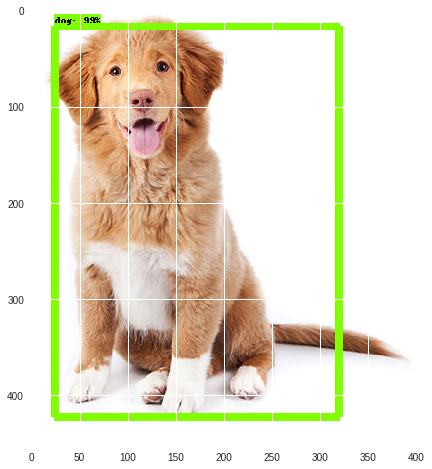

In [89]:

for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  